In [55]:
import sys
import logging
import random
import time

from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.cit import chisq

import pandas as pd
import matplotlib.pyplot as plt
import cstrees.cstree as ct
import cstrees.scoring as sc
import cstrees.stage as st
import cstrees.learning as ctl
import cstrees.ldag as ldag
import networkx as nx
import numpy as np
import pp

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Example: Sachs

In [56]:
sachs = pd.read_csv('../data/sachs_obs_data.csv')

In [57]:
# Binarize data and add a row at the top of the dataframe containing variable cardinalities
sachsnp = sachs.to_numpy()

sachs2 = np.zeros([len(sachs), len(list(sachs.columns))], int)

for i in range(len(list(sachs.columns))):
    sachs2[:,i] = pd.cut(sachsnp[:,i], 2, labels = False)
    
# add row with state space cardinalities
sachs2states = np.zeros([len(sachs) + 1, len(list(sachs.columns))], int)
sachs2states[0,:] = [2 for i in range(len(list(sachs.columns)))]
for i in range(len(sachs)):
    sachs2states[i+1,:] = sachs2[i,:]
    
sachsdf = pd.DataFrame(sachs2states, columns = list(sachs.columns))

In [58]:
# We run without restricting the parent sets according to a CPDAG.
# To run with this restriction uncomment the following:
# pcgraph = pc(sachsdf[1:].values, 0.9, "chisq", node_names=sachsdf.columns)
# poss_cvars = ctl.causallearn_graph_to_posscvars(pcgraph, labels=sachsdf.columns)
# print("Possible context variables per node:", poss_cvars)

start = time.time()
score_table, context_scores, context_counts = sc.order_score_tables(sachsdf,
                                                                    max_cvars=2,
                                                                    alpha_tot=1.0,
                                                                    method="BDeu",
                                                                    poss_cvars=None)

orders, scores = ctl.gibbs_order_sampler(5000, score_table)
end = time.time()
print('Computation time in seconds:', end - start)

Gibbs order sampler: 100%|██████████| 5000/5000 [00:00<00:00, 7099.77it/s]

Computation time in seconds: 76.70792698860168


In [59]:
# optimal variable ordering
sachsmaporder = orders[scores.index(max(scores))]
print(sachsmaporder)

['Mek', 'PIP3', 'PLCg', 'Raf', 'JNK', 'PIP2', 'PKA', 'PKC', 'Akt', 'Erk', 'p38']


In [60]:
# get optimal tree for ordering
sachsopttree = ctl._optimal_cstree_given_order(sachsmaporder, context_scores)


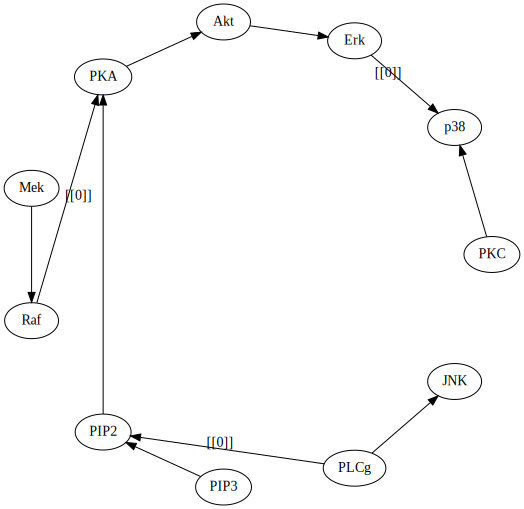

In [61]:
# Print the LDAG representation of the learned CStree model:
agraph = ldag.plot_LDAG(sachsopttree, varorder=sachsmaporder, 
                        graphviz_args="-Goneblock=True",
                        graphviz_prog="circo")
agraph
#agraph.draw('sachs_CStree_LDAG.png')
